# Modelo predictivo valor EUR/USD- Reto 3

## ➡️ Contexto

*NUWE EVA* es una cadena de restaurantes innovadora y disruptiva que emplea robots para realizar todas las tareas humanas. Además de esta característica única, también buscan diferenciarse de los demás restaurantes en la forma en que asignan los precios a su carta. Han decidido vincular los precios del menú a las fluctuaciones del mercado de divisas, específicamente en el valor *EUR/USD*.

Si bien esta estrategia de pricing tiene el potencial de atraer a muchos comensales curiosos, también presenta un riesgo significativo para la estabilidad del negocio debido a la imprevisibilidad de los ingresos.

## 📄 Dataset

Para este reto tendréis dos archivos descargables: un `training_set.csv` y `testing_set.csv`. El primero se debe emplear para el entrenamiento del modelo, y el segundo para introducirlo como input a tu modelo y entregar las predicciones. Abajo los parámetros que hay tener en cuenta:

* `Time`: Indica la fecha y hora en la que se registró el precio del par de divisas EUR/USD. Esto es fundamental para analizar las fluctuaciones y tendencias del mercado en diferentes períodos de tiempo.

* `Open`: Representa el precio de apertura del par EUR/USD en el período de tiempo especificado. Es el primer precio registrado al comienzo de dicho intervalo, como una hora, un día o una semana.

* `High`: Muestra el precio más alto alcanzado por el par EUR/USD durante el período de tiempo analizado. Este valor es útil para identificar los niveles de resistencia en el análisis técnico.

* `Low`: Refleja el precio más bajo alcanzado por el par EUR/USD en el período de tiempo estudiado. Este valor es relevante para determinar los niveles de soporte en el análisis técnico.

* `Close`: Indica el precio de cierre del par EUR/USD en el período de tiempo especificado. Es el último precio registrado antes de que finalice dicho intervalo, proporcionando una idea de cómo terminó la sesión de negociación.

* `Volume`: Muestra la cantidad de unidades de EUR/USD negociadas durante el período. El volumen puede ayudar a identificar la fuerza de una tendencia o confirmar la validez de un movimiento de precios.

* `Label`: Es la clase que les permitirá predecir ciertas dinámicas del mercado, permitiéndoles así estimar los márgenes de beneficio que tendrán en sus menús con antelación. Esta será la variable que se tendrá que predecir en el dataset de test.

## 🎯 Objetivo
Crea un modelo predictivo de clasificación para poder entender las dinámicas de movimiento del *EUR/USD*, únicamente en base a valores del pasado y presente y por último integra el uso de *APEX* en el mismo.
1. Realiza un análisis exploratorio de los datos empleando *APEX*.
2. Crea un modelo predictivo que maximice la puntuación F1-score (macro). Entrenando tu modelo con el dataset de training (trainig_test.csv), y efectuando las predicciones sobre el dataset de testing (testing_set.csv).
3. Crea una presentación (máx 9 slides) con la siguiente estructura:
* Portada.
* Análisis exploratorio de los datos:
    - Resumen y visualizaciones clave.
* Preprocesamiento de los datos:
    - Pasos principales y criterios utilizados.
* Modelos y técnicas de predicción:
    - Modelos seleccionados y justificación.
* Entrenamiento, validación y resultados:
    - Proceso y métricas principales.
* Conclusiones.
Se pueden usar fuentes de datos externas para la resolución del reto, como por ejemplo datos históricos de tweets, noticias, etc.

**IMPORTANTE**:

Hay que tener cuidado de no incurrir en el look-ahead bias. Esto será penalizado. El modelo solo puede utilizar valores actuales `t` o pasados `(t-1,...t-n)` como elementos predictivos. Si el modelo emplea datos futuros, es decir `t+n`, el modelo estaría accediendo a información futura, por lo que la predicción no será válida.

**EJEMPLO**:

Para predecir el label del día 18 de Mayo de 2018, el modelo tan solo podrá usar las variables de predicción referentes al 18 de Mayo de 2018 y de los días previos (17,16,15... de Mayo de 2018).

In [134]:
from numpy import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# 0. Importacion del Dataset

In [135]:
''' load data '''
train = pd.read_csv('./Data/train.csv',index_col = [0], parse_dates = ['Time'])
test = pd.read_csv('./Data/test.csv',index_col = [0], parse_dates = ['Time'])

In [136]:
# Display the first 5 rows of the training dataset to inspect the data
train.head()

,Time,Open,High,Low,Close,Volume,label
train_idx,,,,,,,
0,2007-03-07,1.31258,1.31844,1.31086,1.31648,1807377.0,0
1,2007-03-08,1.31667,1.31813,1.31154,1.31396,1995920.0,1
2,2007-03-09,1.31396,1.31583,1.30864,1.31118,1859100.0,1
3,2007-03-11,1.31236,1.31415,1.31068,1.31175,192381.0,1
4,2007-03-12,1.31193,1.31992,1.31054,7.90878,2009286.0,1


In [137]:
# Display the last 5 rows of the training dataset to inspect the data
train.tail()

,Time,Open,High,Low,Close,Volume,label
train_idx,,,,,,,
3504,2018-05-18,1.18053,1.18221,1.17498,1.17689,220609.0,1
3505,2018-05-20,1.17684,1.17756,1.17441,1.17474,18855.0,0
3506,2018-05-21,1.17473,1.17973,1.17165,1.17913,227861.0,0
3507,2018-05-22,1.17914,1.18296,1.17567,1.17824,255729.0,0
3508,2018-05-23,1.17825,1.17877,1.16758,1.17069,316034.0,0


In [138]:
test.head()

,Time,Open,High,Low,Close,Volume
test_idx,,,,,,
0,2018-05-29,1.16271,1.16394,1.15099,1.15343,336090
1,2018-05-30,1.15342,1.16759,1.15186,1.16627,318421
2,2018-05-31,1.16627,1.17243,1.16410,1.16938,285788
3,2018-06-01,1.16937,1.17178,1.16170,1.16584,253533
4,2018-06-03,1.16561,1.16794,1.16561,1.16757,14803


In [139]:
test.tail()

,Time,Open,High,Low,Close,Volume
test_idx,,,,,,
1495,2023-03-09,1.05466,1.05993,1.05378,1.05986,355706
1496,2023-03-10,1.05985,1.07004,1.05738,1.06387,563206
1497,2023-03-12,1.06808,1.07030,1.06740,1.06815,76674
1498,2023-03-13,1.06814,1.07484,1.06500,1.07189,741112
1499,2023-03-14,1.07189,1.07211,1.06787,1.07061,157347


In [140]:
# values of the target
train.label.value_counts() # balanced

0    1755
1    1754
Name: label, dtype: int64

In [141]:
# Display the data types of each column in the train dataframe
train.dtypes

Time      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume           float64
label              int64
dtype: object

# 1. Exploratory Data Analysis

In [142]:
''' shape of the data '''
print(f'train shape: {train.shape}')
print(f'test shape: {test.shape}')

train shape: (3509, 7)
test shape: (1500, 6)


In [143]:
''' missing values train '''
# calculate the number of missings and the %
pd.DataFrame([train.isna().sum(),train.isna().sum()*100/train.shape[0]],index = ['conteo missing','% missings']).T

,conteo missing,% missings
Time,0.0,0.000000
Open,18.0,0.512967
High,56.0,1.595896
Low,67.0,1.909376
Close,39.0,1.111428
Volume,28.0,0.797948
label,0.0,0.000000


In [144]:
''' missing values test '''
pd.DataFrame([test.isna().sum(),test.isna().sum()*100/test.shape[0]],index = ['conteo missing','% missings']).T

,conteo missing,% missings
Time,0.0,0.0
Open,0.0,0.0
High,0.0,0.0
Low,0.0,0.0
Close,0.0,0.0
Volume,0.0,0.0


In [145]:
''' duplicated values '''
print(f'valores duplicados en train: {train.duplicated().sum()}')
print(f'valores duplicados en test: {test.duplicated().sum()}')

valores duplicados en train: 0
valores duplicados en test: 0


## Numeric Data Exploration

In [146]:
''' distribution of the numeric variables '''
# Call the describe method on the train dataset to get a summary of its numerical variables.
# The T method transposes the output to display the summary statistics horizontally instead of vertically.
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,3491.0,1.315917,0.463695,0.136331,1.181970,1.313140,1.376900,1.260450e+01
High,3453.0,1.308379,0.361848,0.133119,1.184600,1.318720,1.381560,1.152279e+01
Low,3442.0,1.298522,0.367142,0.133926,1.176797,1.307255,1.372110,1.087128e+01
Close,3470.0,1.309465,0.406838,0.132743,1.181277,1.313005,1.376593,1.087704e+01
Volume,3481.0,279384.302253,299512.522504,497.000000,81228.000000,191209.000000,269974.000000,2.693602e+06
label,3509.0,0.499858,0.500071,0.000000,0.000000,0.000000,1.000000,1.000000e+00


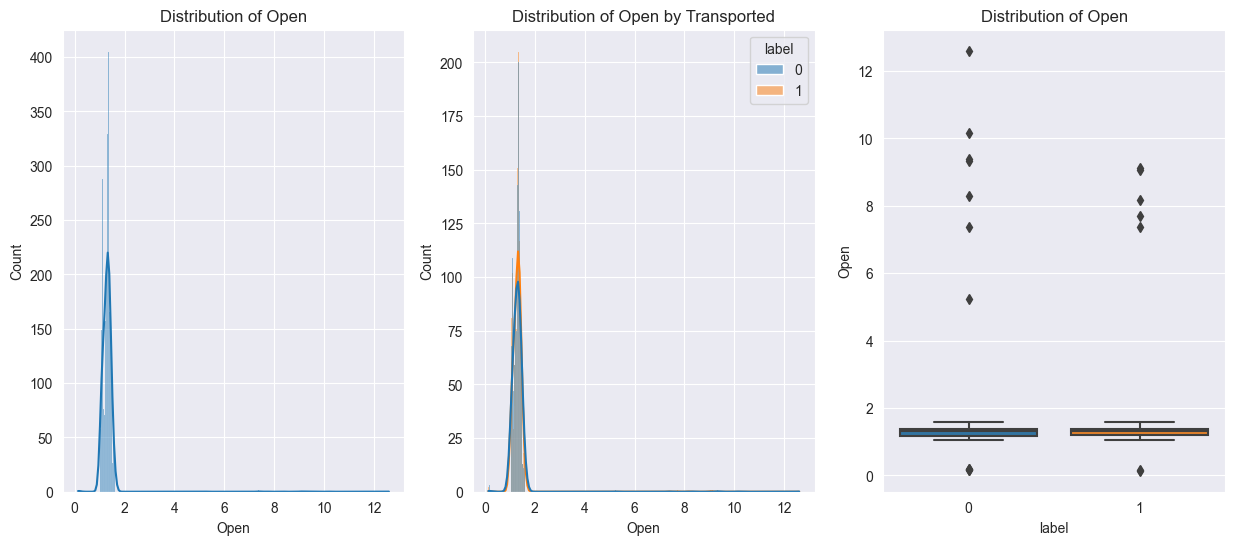

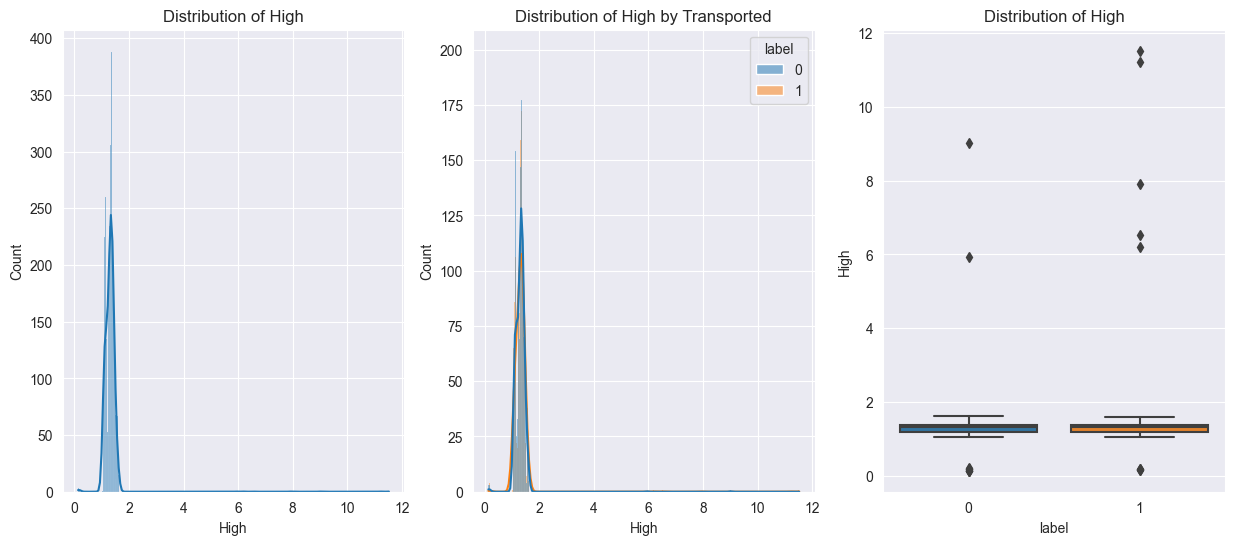

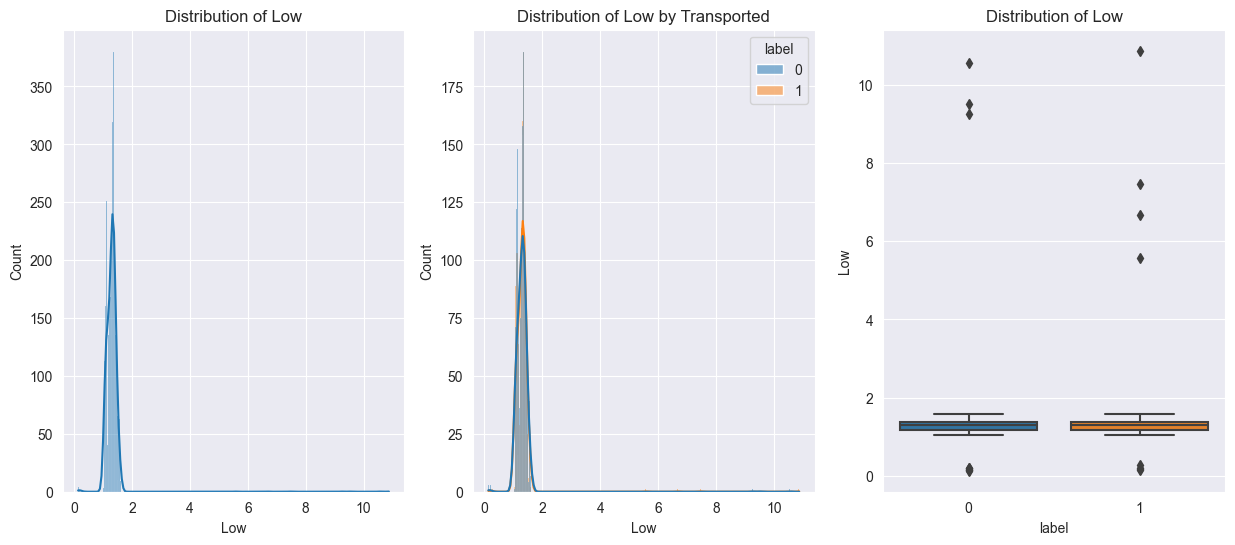

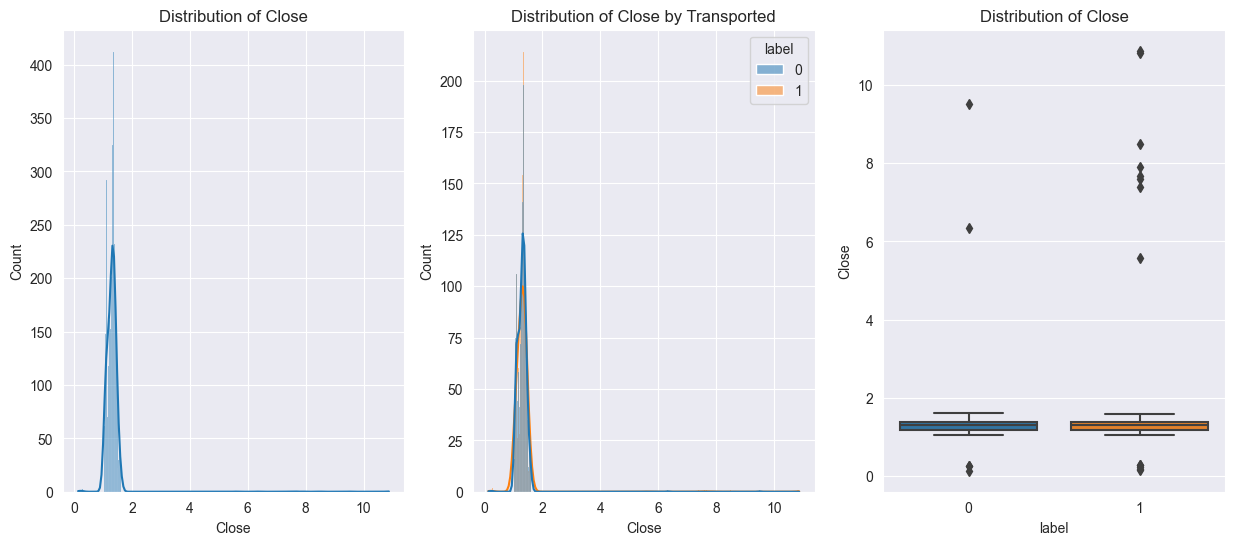

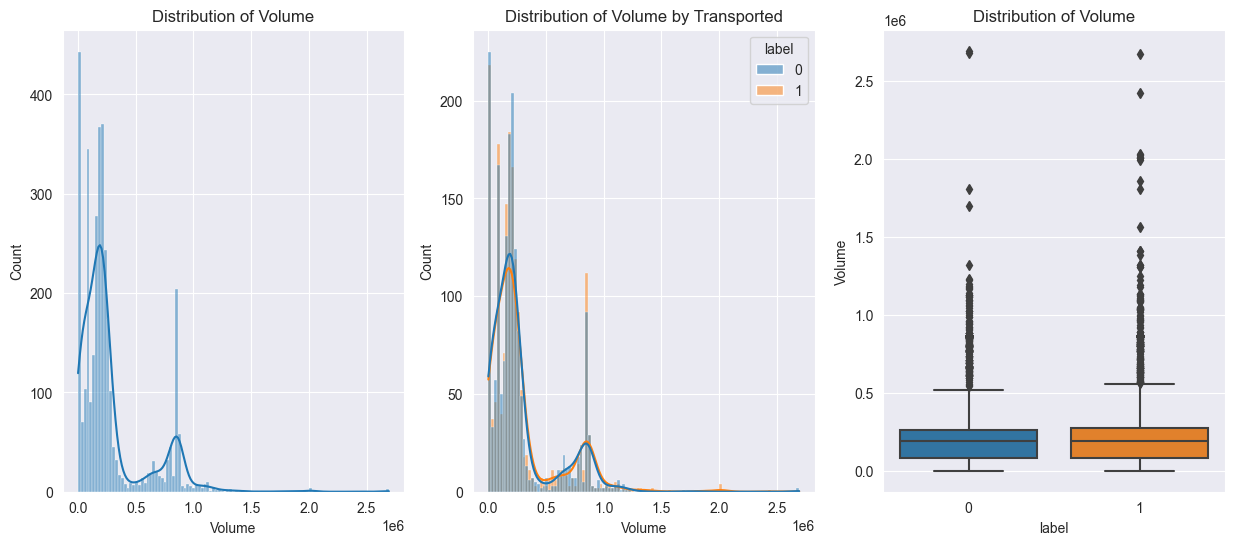

In [147]:
''' graphical distribution of the numeric variables '''
# select numerical columns
numerical_cols = [cname for cname in train.columns if train[cname].dtype in ['int64', 'float64']]
for i in numerical_cols:
    if i != 'label':
        plt.figure(figsize=(15,6))
        plt.subplot(1,3,1)
        ax = sns.histplot(data = train, x = i, kde = True)
        # Set the title to "Distribution of {column}
        ax.set_title(f"Distribution of {i}")
        plt.subplot(1,3,2)
        ax = sns.histplot(data = train, x = i, hue= 'label', kde = True)
        # Set the title to "Distribution of {column} by Transported
        ax.set_title(f"Distribution of {i} by Transported")
        plt.subplot(1,3,3)
        ax = sns.boxplot(data = train, x = 'label' , y = i)
        # Set the title to "Distribution of {column}
        ax.set_title(f"Distribution of {i}")
        plt.show()

<Figure size 1000x600 with 0 Axes>

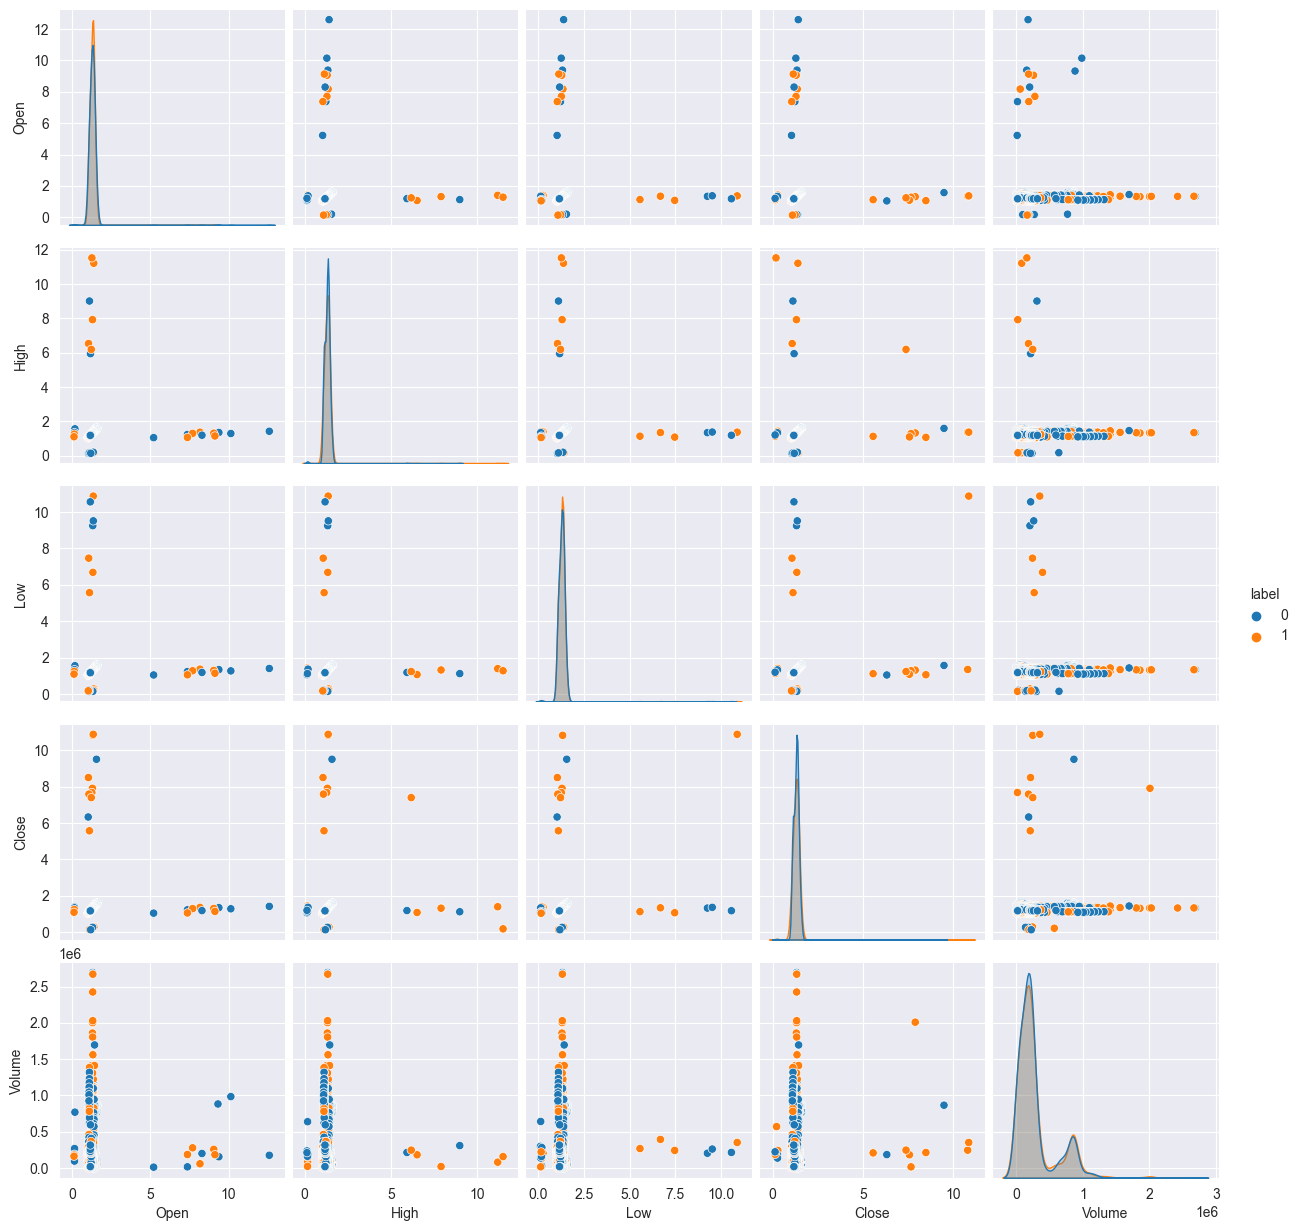

In [148]:
# Plot pairwise relationships between selected features
plt.figure(figsize = (10,6))
sns.pairplot(train[numerical_cols], hue='label')
plt.show()
# 'hue' parameter specifies the column in the dataset that determines the color of the points
# In this case, the points will be colored according to the 'Transported' column, which indicates
# whether or not a person was transported to the vacation location via a special mode of transport.
# The pairplot will show the pairwise relationships between the selected features, with different
# colors indicating whether or not a person was transported.

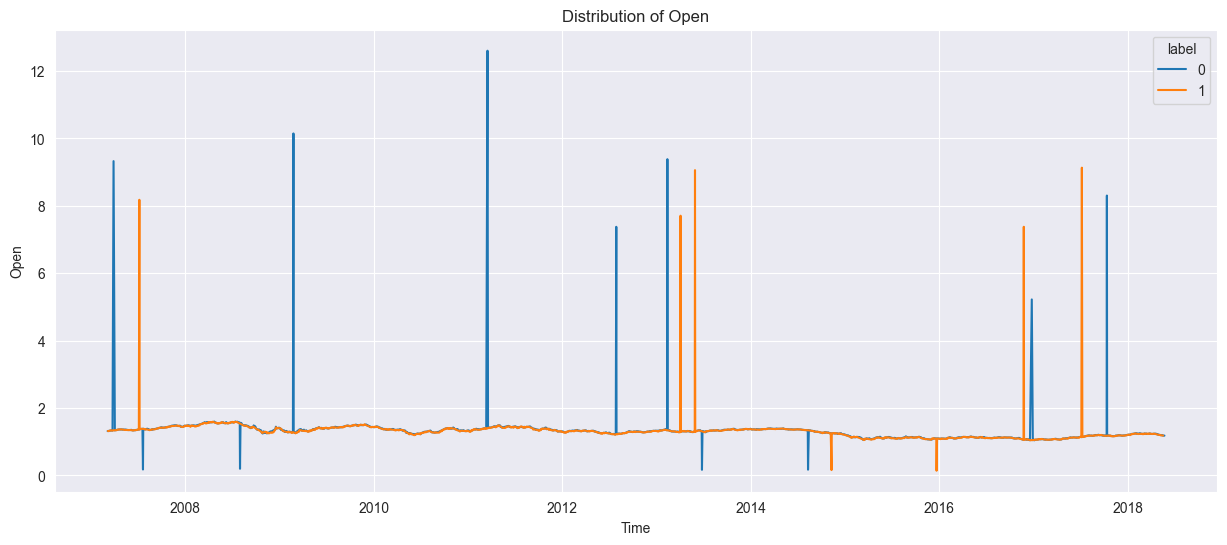

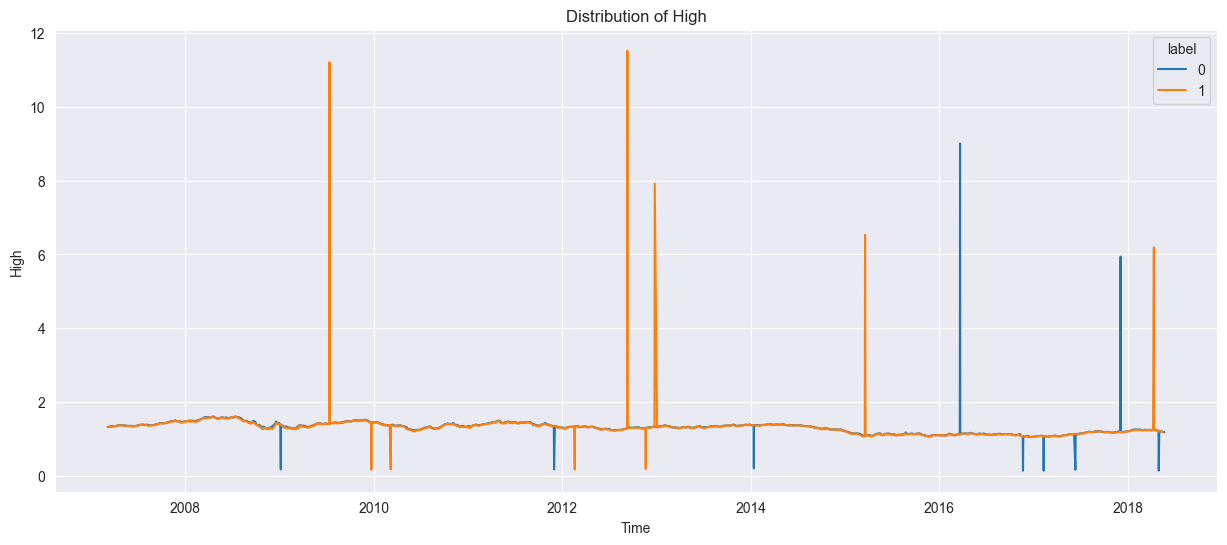

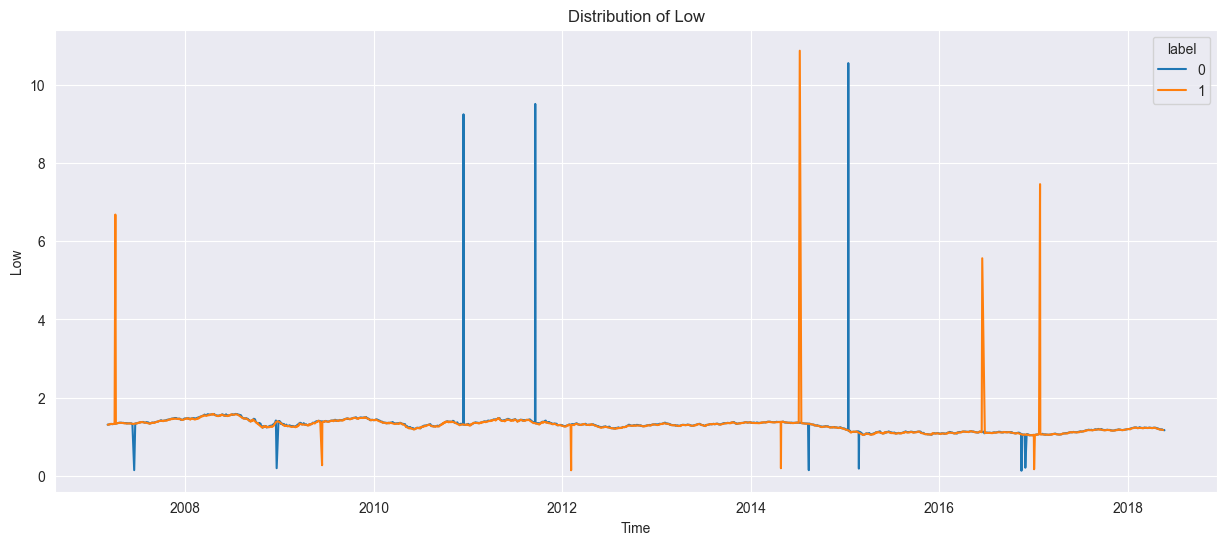

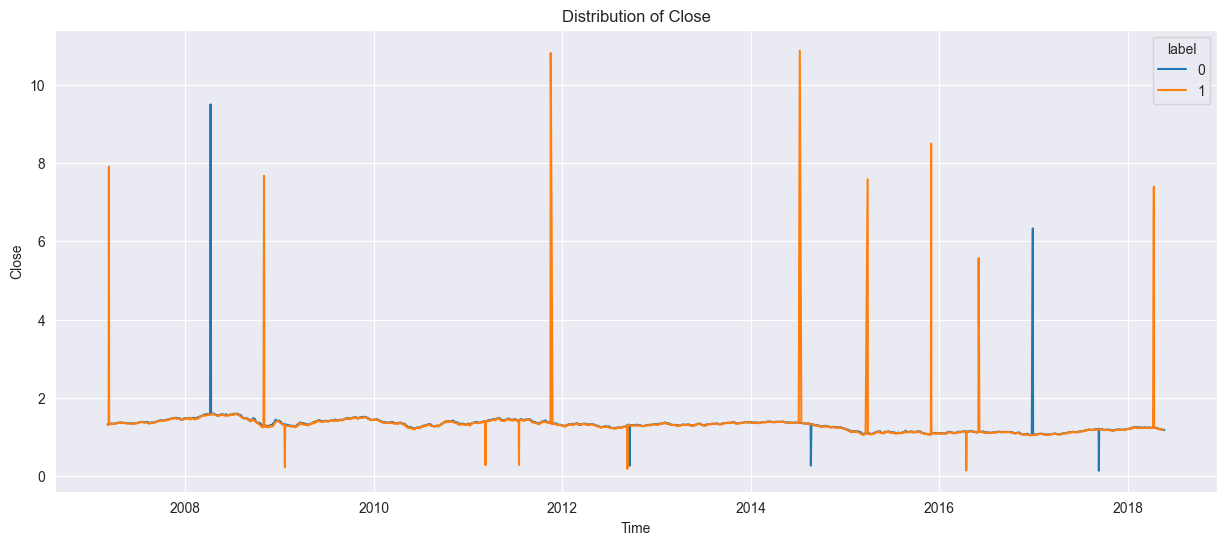

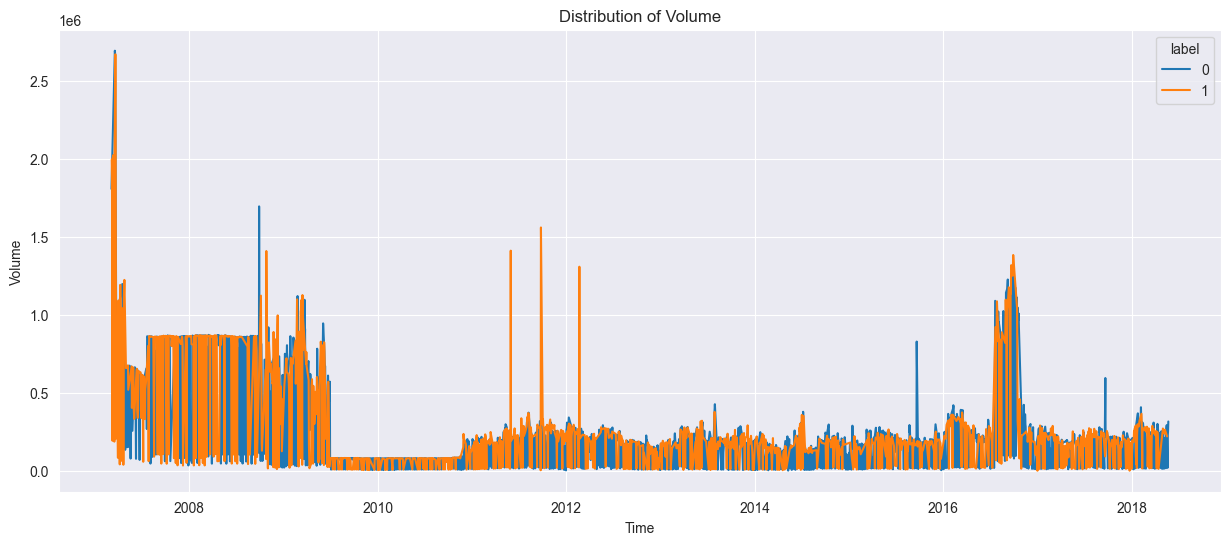

In [149]:
''' graphical distribution of the numeric variables '''
# select numerical columns
numerical_cols = [cname for cname in train.columns if train[cname].dtype in ['int64', 'float64']]
for i in numerical_cols:
    if i != 'label':
        plt.figure(figsize=(15,6))
        ax = sns.lineplot(data = train, x = 'Time' , y = i, hue = 'label')
        # Set the title to "Distribution of {column}
        ax.set_title(f"Distribution of {i}")
        plt.show()

In [150]:
def separatetime(df):
    # we separate the timestamp to 3 columns: day-month-year
    df['day'] = df.Time.dt.day
    df['month'] = df.Time.dt.month
    df['year'] = df.Time.dt.year
    cols = df.columns.tolist()
    cols = cols[-3:] + cols[:-3]
    df = df[cols]
    return df

In [151]:
train = separatetime(train)
test = separatetime(test)

In [152]:
def imputer(train):
    # impute the rest of the variables
    knn = KNNImputer(n_neighbors=int(sqrt(train.shape[0])), weights= 'distance', metric= 'nan_euclidean')
    # I have to tell him that the reference columns for the nearest neighbors
    # must be numeric, although it can be fine-tuned.
    Train = pd.DataFrame(knn.fit_transform(train.drop(['Time'],axis=1)), columns = train.drop(['Time'],axis=1).columns)
    Train['Time'] = train['Time']
    cols = Train.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    Train = Train[cols]
    for x in Train.columns:
        Train[x]=Train[x].astype(train[x].dtypes.name)
    return Train

In [153]:
train = imputer(train)
train.head()

,Time,day,month,year,Open,High,Low,Close,Volume,label
0,2007-03-07,7,3,2007,1.31258,1.31844,1.31086,1.31648,1807377.0,0
1,2007-03-08,8,3,2007,1.31667,1.31813,1.31154,1.31396,1995920.0,1
2,2007-03-09,9,3,2007,1.31396,1.31583,1.30864,1.31118,1859100.0,1
3,2007-03-11,11,3,2007,1.31236,1.31415,1.31068,1.31175,192381.0,1
4,2007-03-12,12,3,2007,1.31193,1.31992,1.31054,7.90878,2009286.0,1


In [154]:
def Transformer(train,test):
    # we define the numerical cols of the dataframe
    numerical_cols = [cname for cname in train.drop(['day','month','year'],axis=1).columns if train[cname].dtype in ['int64', 'float64']]
    yeo = PowerTransformer(method='yeo-johnson')
    sc = StandardScaler()
    # Pipeline for numericals
    num_pipe = Pipeline(steps=[('powert',yeo), # make gaussian
                           ('scaler',sc)]) # estandarize
    # Bundle preprocessing for numerical and categorical data
    preprocessor = ColumnTransformer(transformers=[
            ('num',num_pipe, numerical_cols)])
    # this is just to eliminate the prefix 'num' and 'cat' of the variables
    preprocessor.fit(train)
    names = []
    for i in preprocessor.get_feature_names_out():
        names.append(i[5:])
    # we finally save the preprocessing in the dataframe we're gonna use to make the models
    Train = pd.DataFrame(preprocessor.fit_transform(train), columns = names)
    Train[['day','month','year','Time']] = train[['day','month','year','Time']]
    cols = Train.columns.tolist()
    cols = cols[-4:] + cols[:-4]
    Train = Train[cols]
    Test = pd.DataFrame(preprocessor.transform(test), columns = names)
    Test[['day','month','year','Time']] = test[['day','month','year','Time']]
    cols = Test.columns.tolist()
    cols = cols[-4:] + cols[:-4]
    Test = Test[cols]
    return Train,Test

In [155]:
Xtrain , Xtest = Transformer(train.drop(['label'],axis=1),test)
Xtrain['label'] = train.label

In [156]:
Xtrain.head()

,day,month,year,Time,Open,High,Low,Close,Volume,label
0,7,3,2007,2007-03-07,0.143127,0.147570,0.167487,0.171314,2.643854,0
1,8,3,2007,2007-03-08,0.164350,0.146006,0.171019,0.158113,2.792947,1
2,9,3,2007,2007-03-09,0.150297,0.134390,0.155942,0.143515,2.685904,1
3,11,3,2007,2007-03-11,0.141983,0.125892,0.166552,0.146511,0.042840,1
4,12,3,2007,2007-03-12,0.139747,0.155033,0.165824,8.645441,2.803098,1


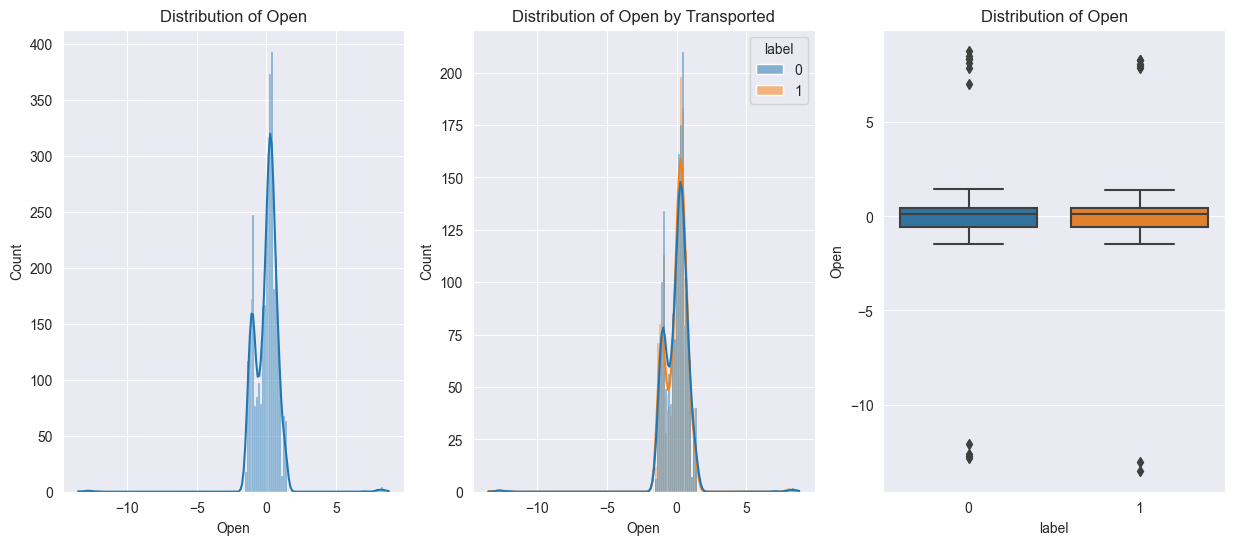

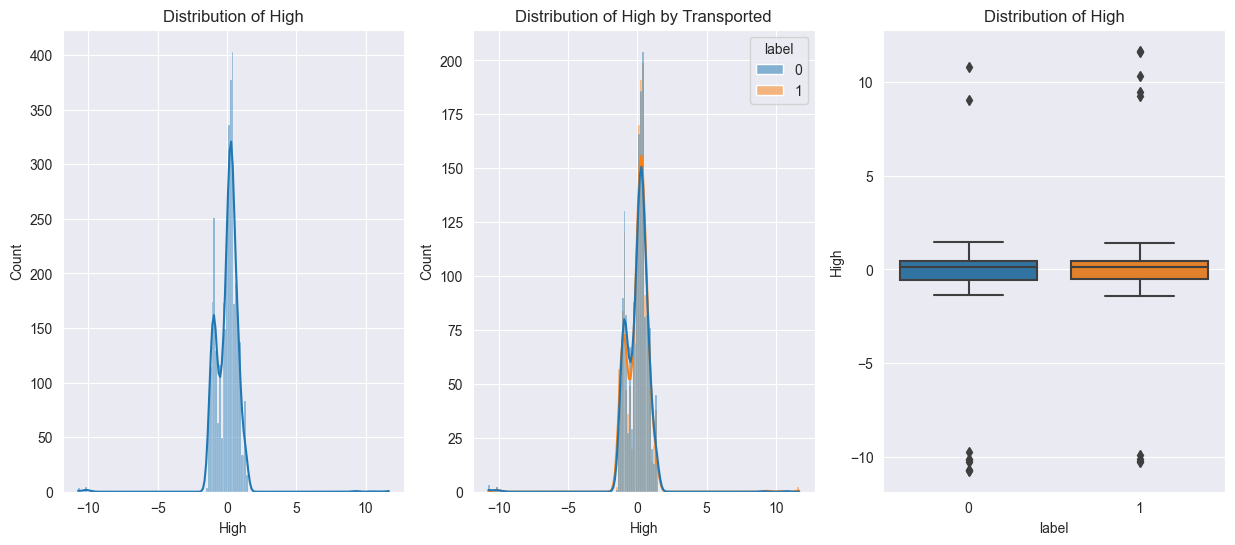

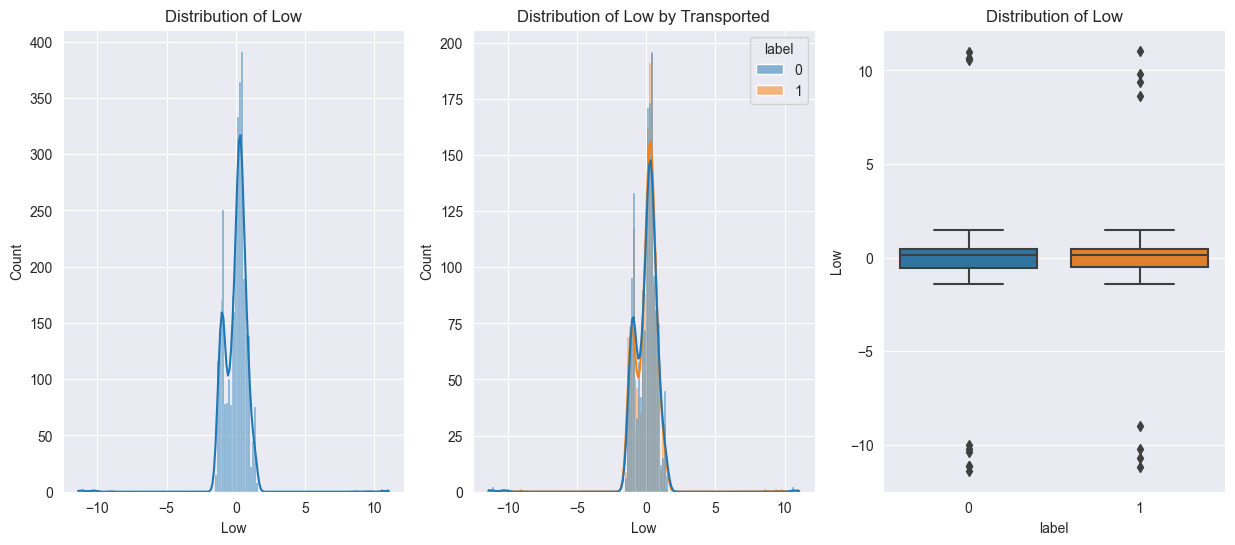

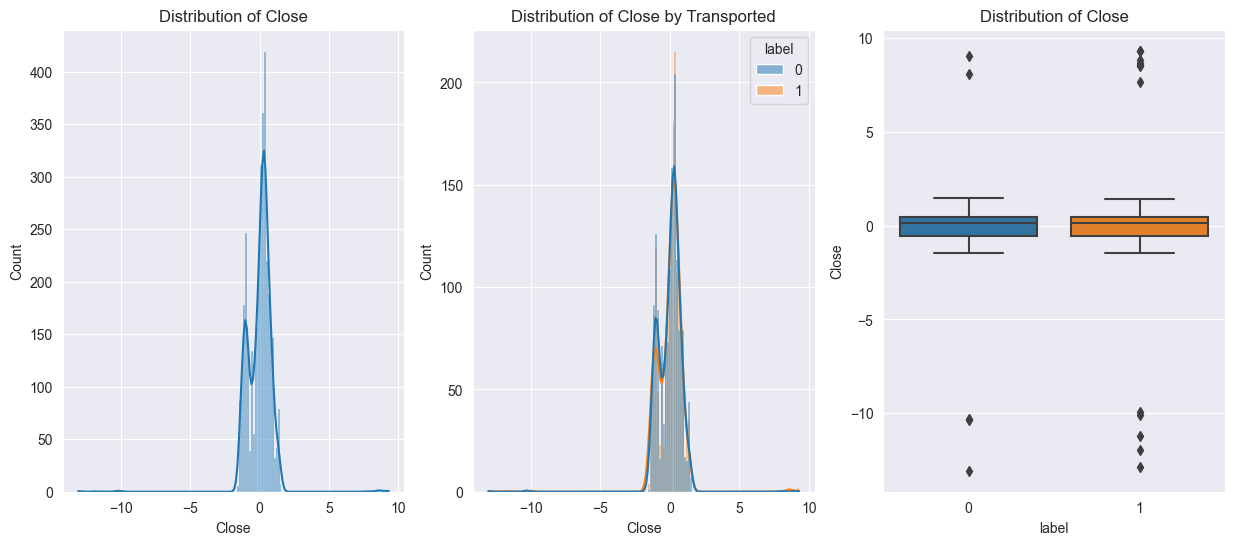

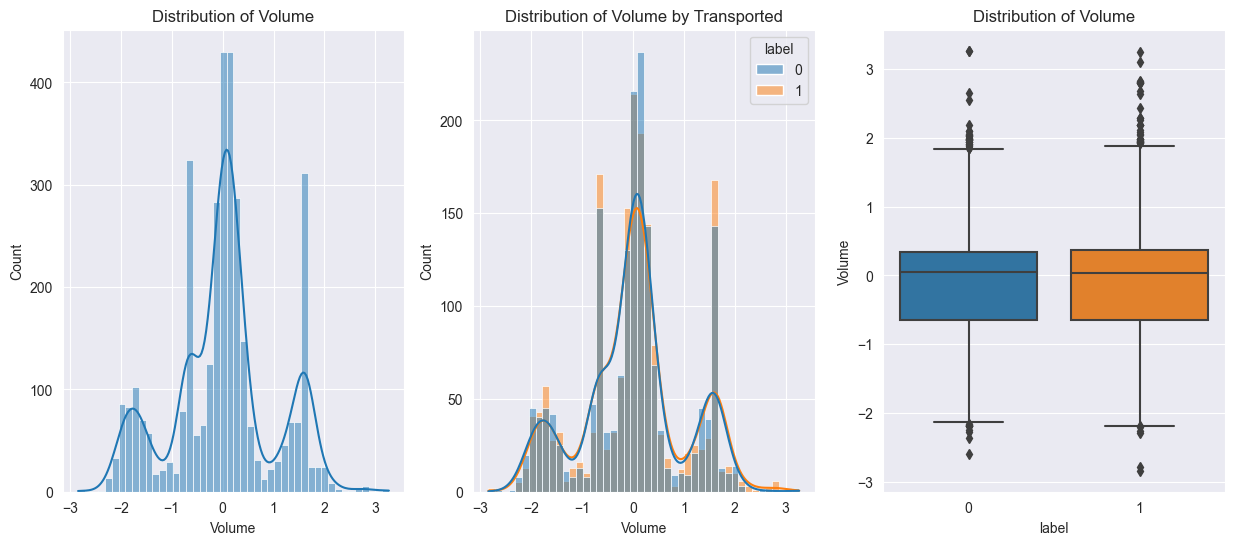

In [187]:
''' graphical distribution of the numeric variables '''
# select numerical columns
numerical_cols = [cname for cname in Xtrain.drop(['day','month','year'],axis=1).columns if Xtrain[cname].dtype in ['int64', 'float64']]
for i in numerical_cols:
    if i != 'label':
        plt.figure(figsize=(15,6))
        plt.subplot(1,3,1)
        ax = sns.histplot(data = Xtrain, x = i, kde = True)
        # Set the title to "Distribution of {column}
        ax.set_title(f"Distribution of {i}")
        plt.subplot(1,3,2)
        ax = sns.histplot(data = Xtrain, x = i, hue= 'label', kde = True)
        # Set the title to "Distribution of {column} by Transported
        ax.set_title(f"Distribution of {i} by Transported")
        plt.subplot(1,3,3)
        ax = sns.boxplot(data = Xtrain, x = 'label' , y = i)
        # Set the title to "Distribution of {column}
        ax.set_title(f"Distribution of {i}")
        plt.show()

In [175]:
xtrain, xtest = Xtrain[Xtrain.year <= 2017].drop(['Time'],axis = 1), Xtrain[Xtrain.year > 2017].drop(['Time'],axis = 1)
ytrain = xtrain.pop('label')
ytest = xtest.pop('label')

In [179]:
ytrain.value_counts()

1    1701
0    1685
Name: label, dtype: int64

In [184]:
xgb = XGBClassifier()

xgb.fit(xtrain, ytrain)
print(f'classification report XGBoost:')
print(classification_report(ytest, xgb.predict(xtest)))

classification report XGBoost:
              precision    recall  f1-score   support

           0       0.50      0.63      0.56        70
           1       0.26      0.17      0.20        53

    accuracy                           0.43       123
   macro avg       0.38      0.40      0.38       123
weighted avg       0.40      0.43      0.41       123

